In [2]:
import pandas as pd
import numpy as np

# Load
df = pd.read_csv("dataset2.csv")

# Standardize column names
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(' ', '_')
              .str.replace('(', '', regex=False)
              .str.replace(')', '', regex=False)
)

# Split serving_size into amount and unit
serv = df['serving_size'].str.extract(r'(?P<amount>[\d\.]+)\s*(?P<unit>oz|g|fl oz|ml|cup|carton|cookie|piece|bottle)', expand=True)
df['serving_amount'] = pd.to_numeric(serv['amount'], errors='coerce')
df['serving_unit'] = serv['unit']

# Coerce numerics for key nutrition fields
num_cols = [
    'calories','calories_from_fat','total_fat','saturated_fat','trans_fat','cholesterol',
    'sodium','carbohydrates','dietary_fiber','sugars','protein',
    'vitamin_a_%_daily_value','vitamin_c_%_daily_value','calcium_%_daily_value','iron_%_daily_value'
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop exact duplicates, handle obvious anomalies
df = df.drop_duplicates()
# Optional: remove rows with missing key fields
df = df.dropna(subset=['category','item','calories','sodium','carbohydrates'])

# Derived features
df['cal_density_per_oz'] = np.where(df['serving_unit'].eq('oz'), df['calories'] / df['serving_amount'], np.nan)
df['sugar_ratio'] = df['sugars'] / (df['carbohydrates'].replace(0, np.nan))
df['fat_kcal_share'] = df['calories_from_fat'] / df['calories']

In [3]:
# Overall stats
desc = df[num_cols].describe()

# Mode (most frequent value) per numeric column
modes = {c: df[c].mode().iloc[0] if not df[c].mode().empty else np.nan for c in num_cols}

# By category (mean/median)
by_cat_mean = df.groupby('category')[num_cols].mean().sort_values('calories', ascending=False)
by_cat_median = df.groupby('category')[num_cols].median().sort_values('calories', ascending=False)

# Calorie density and sodium highlights
top_cal_dense = df[['category','item','cal_density_per_oz']].dropna().sort_values('cal_density_per_oz', ascending=False).head(10)
top_sodium = df[['category','item','sodium']].sort_values('sodium', ascending=False).head(10)
low_cal_options = df[['category','item','calories']].sort_values('calories').head(10)

In [4]:
# Example composite health score (lower is better risk)
from sklearn.preprocessing import MinMaxScaler

risk_cols = ['calories','sodium','sugars','saturated_fat']
X = df[risk_cols].copy()
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(X), columns=[f'{c}_scaled' for c in risk_cols])

df[['cal_scaled','sod_scaled','sug_scaled','satfat_scaled']] = scaled.values
df['health_risk_score'] = (
    0.35 * df['sod_scaled'] +
    0.30 * df['satfat_scaled'] +
    0.20 * df['cal_scaled'] +
    0.15 * df['sug_scaled']
)

product_risk = df[['category','item','health_risk_score']].sort_values('health_risk_score', ascending=False)

In [5]:
q90 = df['health_risk_score'].quantile(0.9)
q10 = df['health_risk_score'].quantile(0.1)
df['risk_band'] = pd.cut(df['health_risk_score'],
                         bins=[-np.inf, q10, q90, np.inf],
                         labels=['better_choice','mid','high_risk'])

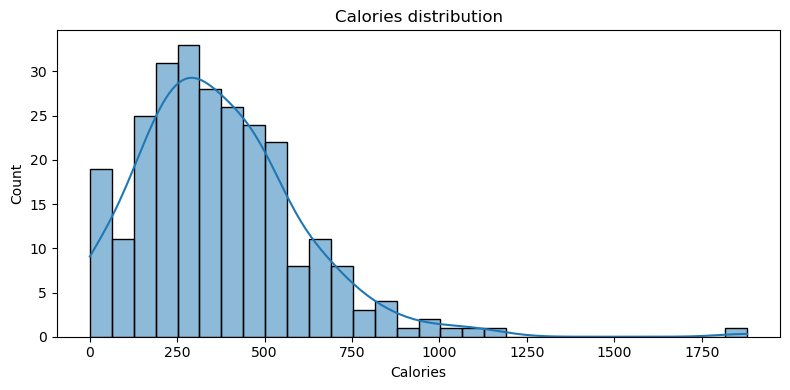

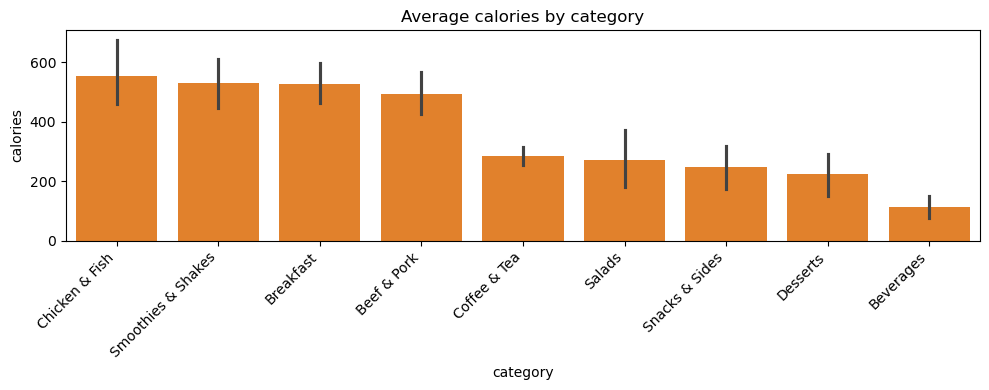

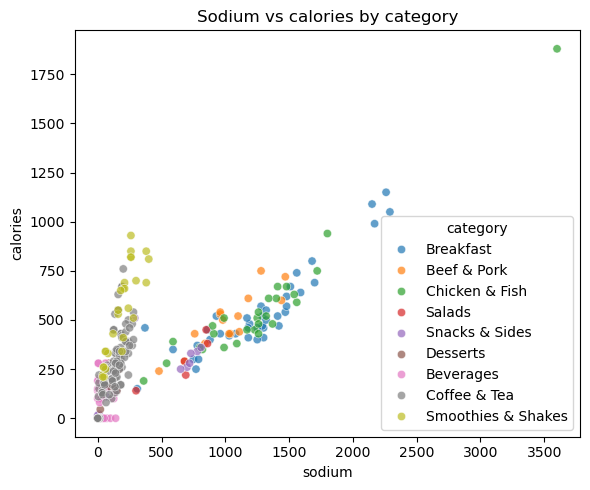

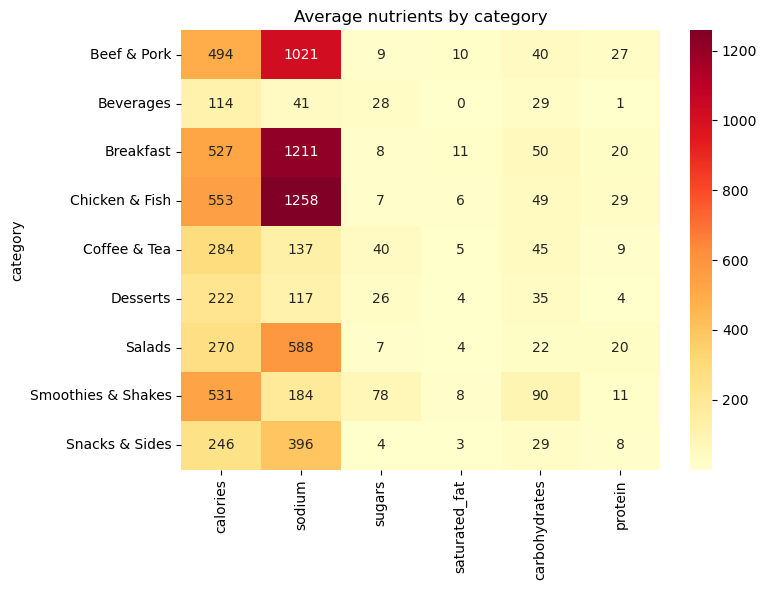

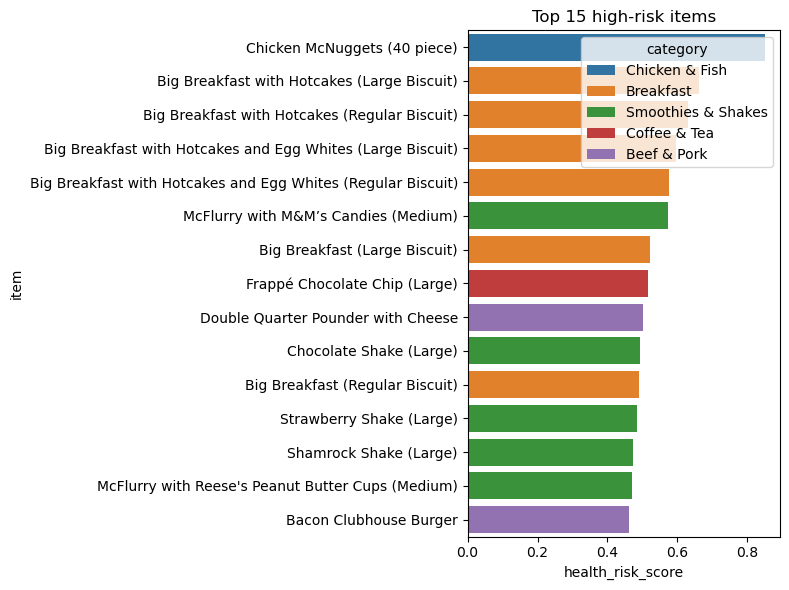

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Calories distribution
plt.figure(figsize=(8,4))
sns.histplot(df['calories'], bins=30, kde=True, color='#1f77b4')
plt.title('Calories distribution')
plt.xlabel('Calories')
plt.tight_layout()

# 2) Category-wise averages (bar)
cat_order = df.groupby('category')['calories'].mean().sort_values(ascending=False).index
plt.figure(figsize=(10,4))
sns.barplot(data=df, x='category', y='calories', order=cat_order, estimator=np.mean, color='#ff7f0e')
plt.title('Average calories by category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 3) Sodium vs calories (scatter)
plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x='sodium', y='calories', hue='category', alpha=0.7)
plt.title('Sodium vs calories by category')
plt.tight_layout()

# 4) Heatmap: category x nutrient (means)
heat = df.groupby('category')[['calories','sodium','sugars','saturated_fat','carbohydrates','protein']].mean()
plt.figure(figsize=(8,6))
sns.heatmap(heat, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Average nutrients by category')
plt.tight_layout()

# 5) Top high-risk items
top_risk = df.sort_values('health_risk_score', ascending=False).head(15)
plt.figure(figsize=(8,6))
sns.barplot(data=top_risk, y='item', x='health_risk_score', hue='category', dodge=False)
plt.title('Top 15 high-risk items')
plt.tight_layout()